In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join('.', 'preprocessing')))
from preprocessing.isochrones import (
    read_matrix_to_df,
    merge_traveltimes_to_grid,
    dissolve_grid_to_isochrones,
)

In [2]:
def plot_isochrones(isochrones, grid):
    fig, ax = plt.subplots(figsize=(20, 10))

    grid.dissolve().plot(ax=ax, color="lightgray")
    isochrones.plot(
        ax=ax,
        column="t",
        legend=True,
        categorical=True,
        cmap="cividis_r",
    )

In [3]:
grid = gpd.read_file(
    Path("./data/Helsinki_Travel_Time_Matrix_2023_grid.gpkg.zip")
)

grid = grid[["id", "geometry"]].to_crs(epsg=4326)

In [4]:
ykr_id = grid.sample().iloc[0]["id"]
print(ykr_id)

5975375


In [5]:
traveltimes = read_matrix_to_df(
    Path(f"./data/Helsinki_Travel_Time_Matrix_2023/Helsinki_Travel_Time_Matrix_2023_travel_times_to_{ykr_id}.csv"),
    filetype="csv"
)

mode = "pt_r_walk_avg"

tt_grid = merge_traveltimes_to_grid(
    grid,
    traveltimes,
    mode,
)

tt_isochrones = dissolve_grid_to_isochrones(
    tt_grid,
    breakpoints=[15, 30, 45, 60],
    mode=mode,
)

/var/home/eemil/repos/travel-time-matrix-visualisation-preprocessing/.venv/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


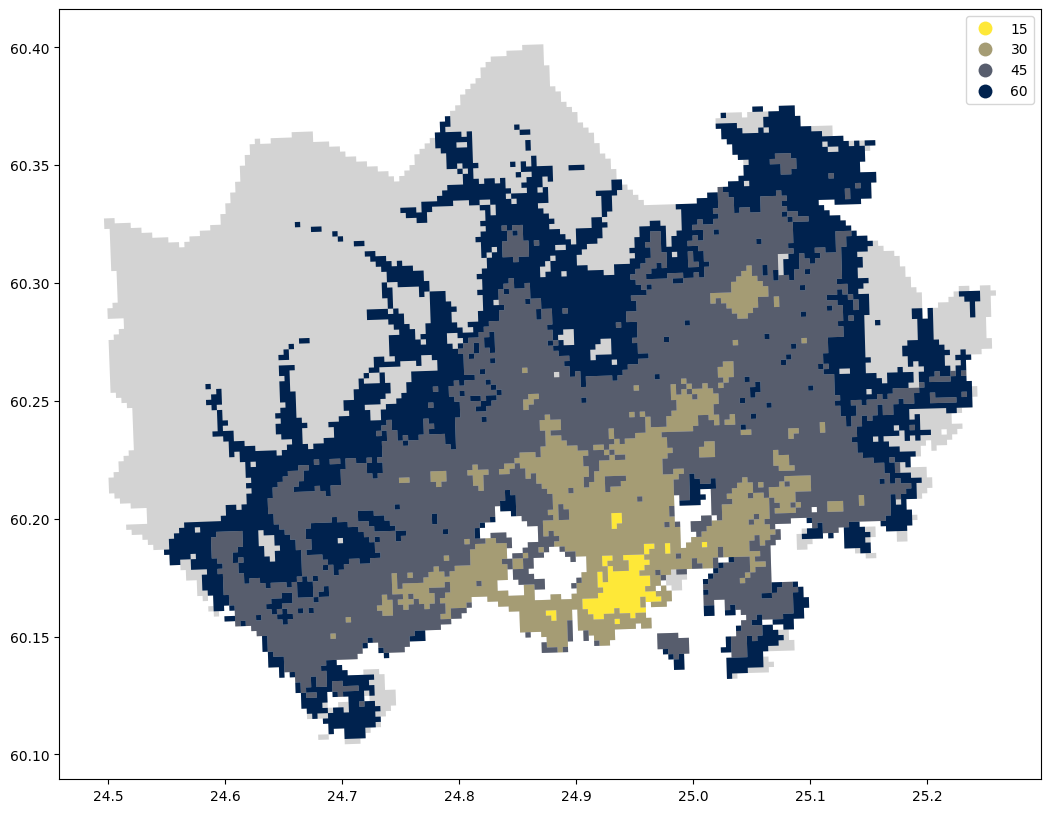

In [6]:
plot_isochrones(tt_isochrones, grid)